In [ ]:
#this notebook reads the experimental data from defined directories
#then a protocol of linear and non-linear fitting on the free energy of the input data is performed
#ultimately the results published in this study are obtained

In [ ]:
#executing this script without changes will load all available training sequences
#no nearest neighbor Sequence information are included
#then a linear and a non-linear fitting procedure is executed
#since the relationship between the input data and their probability of occurence is non-linear, 
#the non-linear fitting procedures reproduces the underlying distribution better than the linear one

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import bussilab
from bussilab import ann
import scipy
from scipy.optimize import minimize

import itertools
import collections

import os

%matplotlib notebook

In [2]:
#get eCLIP dataset

data_dir='./eCLIP/'

file_names=[]
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"): 
        file_names.append(filename)
    else:
        continue

57

In [3]:
inverse_one_hot_encoding = {'A' : np.array([0,0,0,1]), 'C' : np.array([0,0,1,0]),'G': np.array([0,1,0,0]),'U': np.array([1,0,0,0])}
print(inverse_one_hot_encoding)

def inverse_mapping_bit_encode(input_array):
    output=[]
    for i,elem in enumerate(input_array):
        output.append(inverse_one_hot_encoding[elem])
    output=np.array(output)
    return output

def replace_NaNs(input_a):
    where_are_NaNs = np.isnan(input_a)
    input_a[where_are_NaNs] = 0
    input_a[where_are_NaNs] = 0
    return np.array(input_a)

eCLIP=[]
SHAPE=[]
SEQUENCE=[]

for f,file in enumerate(file_names):
    df = pd.read_csv(data_dir+file, index_col = 0, header = 0)

    eclip_event_cols = ['trun_IP1', 'mismatch_IP1', 'ins_IP1', 'del_IP1']
    eclip_event_cols2 = ['trun_IP2', 'mismatch_IP2', 'ins_IP2', 'del_IP2']

    ip1_events = df[eclip_event_cols].sum(axis = 1)
    ip2_events = df[eclip_event_cols2].sum(axis = 1)

    eCLIP.append(np.array(ip1_events+ip2_events))

    SHAPE.append(np.array(df['shape']))

    SEQUENCE.append(np.array(df['ref_seq']))

    one_hot_SEQUENCE=inverse_mapping_bit_encode(SEQUENCE[f])

    eCLIP[f]=replace_NaNs(eCLIP[f]).reshape(-1)
    SHAPE[f]=replace_NaNs(SHAPE[f]).reshape(-1)
    SEQUENCE[f]=replace_NaNs(one_hot_SEQUENCE).reshape(-1,4)


    eCLIP[f]=(eCLIP[f]-np.min(eCLIP[f])+1e-30)/(np.max(eCLIP[f])-np.min(eCLIP[f])+1e-30)

{'A': array([0, 0, 0, 1]), 'C': array([0, 0, 1, 0]), 'G': array([0, 1, 0, 0]), 'U': array([1, 0, 0, 0])}


In [4]:
struct_dir='./Structure/'
STRUCTURE=[]

for f,file in enumerate(file_names):
    file= file.replace(".csv", ".dot")
    df = pd.read_csv(struct_dir+file)
    bracket_notation=df.loc[1][0][:df.loc[1][0].find(' ')]

    #STRUCTURE 0 if ss 1 if ds
    bin_bracket_notation=[]
    for c in bracket_notation:
        if c == '.':
            bin_bracket_notation.append(0)
        else:
            bin_bracket_notation.append(1)
    STRUCTURE.append(np.array(bin_bracket_notation))

In [5]:
del_ndx=[]
for e,elem in enumerate(SEQUENCE):
    if len(elem) < 5:
        del_ndx.append(e)
        
    
SEQUENCE_val=[]
eCLIP_val=[]
SHAPE_val=[]
STRUCTURE_val=[]
for e,elem in enumerate(SEQUENCE):
    if e in del_ndx: 
        SEQUENCE_val.append(SEQUENCE[e])
        eCLIP_val.append(eCLIP[e])
        SHAPE_val.append(SHAPE[e])
        STRUCTURE_val.append(STRUCTURE[e])

print('eCLIP_val',len(eCLIP_val))
print('SHAPE_val',len(SHAPE_val))
print('STRUCTURE_val',len(STRUCTURE_val))
print('SEQUENCE_val',len(SEQUENCE_val))

#generate the training data
SEQUENCE=np.delete(SEQUENCE,del_ndx)
eCLIP=np.delete(eCLIP,del_ndx)
SHAPE=np.delete(SHAPE,del_ndx)
STRUCTURE=np.delete(STRUCTURE,del_ndx)


print('eCLIP',len(eCLIP))
print('SHAPE',len(SHAPE))
print('STRUCTURE',len(STRUCTURE))
print('SEQUENCE',len(SEQUENCE))

eCLIP_val 2
SHAPE_val 2
STRUCTURE_val 2
SEQUENCE_val 2
eCLIP 55
SHAPE 55
STRUCTURE 55
SEQUENCE 55


/u/t/tfrahlki/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [6]:
eCLIP_clipdata=np.copy(eCLIP)
SHAPE_clipdata=np.copy(SHAPE)
STRUCTURE_clipdata=np.copy(STRUCTURE)
SEQUENCE_clipdata=np.copy(SEQUENCE)

In [7]:
#discretize the eCLIP data
def discretizer10(input_arr):
    for s,sys in enumerate(input_arr):
        for e,elem in enumerate(sys):
            #print(elem)
            if elem >= 0 and elem < 0.1:
                input_arr[s][e]=0.0
            if elem >= 0.1 and elem < 0.2:
                input_arr[s][e]=0.1
            if elem >= 0.2 and elem < 0.3:
                input_arr[s][e]=0.2
            if elem >= 0.3 and elem < 0.4:
                input_arr[s][e]=0.3
            if elem >= 0.4 and elem < 0.5:
                input_arr[s][e]=0.4
            if elem >= 0.5 and elem < 0.6:
                input_arr[s][e]=0.5
            if elem >= 0.6 and elem < 0.7:
                input_arr[s][e]=0.6
            if elem >= 0.7 and elem < 0.8:
                input_arr[s][e]=0.7
            if elem >= 0.8 and elem < 0.9:
                input_arr[s][e]=0.8
            if elem >= 0.9 and elem <= 1.0:
                input_arr[s][e]=0.9
                
    return input_arr

def discretizer2(input_arr):
    for s,sys in enumerate(input_arr):
        for e,elem in enumerate(sys):
            if elem < 0.5:
                input_arr[s][e]=int(0)
            if elem >= 0.5:
                input_arr[s][e]=int(1)
                
    return input_arr

eCLIP_clipdata=discretizer2(eCLIP_clipdata) #discretizer2(eCLIP_clipdata) #discretizer10(eCLIP_clipdata) #
SHAPE_clipdata=discretizer2(SHAPE_clipdata) #discretizer2(SHAPE_clipdata) #discretizer10(SHAPE_clipdata) #

eCLIP_val=discretizer2(eCLIP_val) #discretizer2(eCLIP_val) #discretizer10(eCLIP_val) #
SHAPE_val=discretizer2(SHAPE_val) #discretizer2(SHAPE_val) #discretizer10(SHAPE_val) #

55
55
55
55


In [8]:
eCLIP_partitionF=[0,1]
SHAPE_partitionF=[0,1]
#eCLIP_partitionF=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#SHAPE_partitionF=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
STRUCTURE_partitionF=[0,1]
SEQUENCE_partitionF=[[0, 0, 0, 1],[0, 0, 1, 0],[0, 1, 0, 0],[1, 0, 0, 0]]
#STRUCTURE_partitionF=[0.0,1.0]
#SEQUENCE_partitionF=[[0.0, 0.0, 0.0, 1.0],[0.0, 0.0, 1.0, 0.0],[0.0, 1.0, 0.0, 0.0],[1.0, 0.0, 0.0, 0.0]]

partitions_traj=[x for x in itertools.product(eCLIP_partitionF,SHAPE_partitionF, STRUCTURE_partitionF,SEQUENCE_partitionF)]

partitions_traj=np.array(partitions_traj,dtype=object)
eCLIP_all_states=[partitions_traj[:,0]]
SHAPE_all_states=[partitions_traj[:,1]]
STRUCTURE_all_states=[partitions_traj[:,2]]
SEQUENCE_all_states=[]
for elem in partitions_traj[:,3]:
    SEQUENCE_all_states.append(list(elem))
SEQUENCE_all_states=[np.array(SEQUENCE_all_states)]

32


In [9]:
def _logsum(ns):
    max = np.max(ns)
    ds = ns - max
    sumOfExp = np.exp(ds).sum()
    return max + np.log(sumOfExp)

def _softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [10]:
#define the training dataset
eCLIP=eCLIP_clipdata
SHAPE=SHAPE_clipdata
STRUCTURE=STRUCTURE_clipdata
SEQUENCE=SEQUENCE_clipdata  
nsys=len(eCLIP)   

partition_input_data= np.array([eCLIP_all_states[0],SHAPE_all_states[0],STRUCTURE_all_states[0],SEQUENCE_all_states[0][:,0],SEQUENCE_all_states[0][:,1],SEQUENCE_all_states[0][:,2],SEQUENCE_all_states[0][:,3]])
all_states=partition_input_data.T.tolist()

ndx_list_collector=[]
for s in range(nsys):
    input_data= np.array([eCLIP[s],SHAPE[s],STRUCTURE[s],SEQUENCE[s][:,0],SEQUENCE[s][:,1],SEQUENCE[s][:,2],SEQUENCE[s][:,3]])

    index=[]
    for n,nucleo in enumerate(eCLIP[s]):
        check=input_data[:,n].tolist()
        index.append(all_states.index(check))
    ndx_list_collector.append(index)

55


In [11]:
d_U=[]
for s in range(len(ndx_list_collector)):
    d_U.append(np.zeros(len(eCLIP_all_states[0])))
    for i in ndx_list_collector[s]:
        d_U[s][i]+=1
    d_U[s]/=np.sum(d_U[s])

In [12]:
eps=1e-30

def cost_function(par,regularize=True):

    assert(len(par)==npar)
    RBP_net.setpar(par)
    
    cost=0
    derivatives=np.zeros(npar)
       
            
    for s in range(considered_sys):
            partition_func_net=RBP_net.forward(partition_input_data.T)
            u=partition_func_net.f.asarray()[:,0]

            Z=_logsum(-u)
            d_Z=-_softmax(-u)


            cost+=np.dot(u,d_U[s]) + Z
            d_cost=d_U[s]+d_Z

            derivatives+=RBP_net.backward_par(d_cost,partition_func_net)
    
    return cost,derivatives

In [15]:
considered_sys=len(ndx_list_collector)
#build a linear architecture
use_cuda=True
layers=[7] 
RBP_net=ann.ANN(random_weights=True,layers=layers,cuda=use_cuda)
npar=RBP_net.npar
nweights=RBP_net.nparW
print(npar,nweights)
    
eCLIP=eCLIP_clipdata
SHAPE=SHAPE_clipdata
STRUCTURE=STRUCTURE_clipdata
SEQUENCE=SEQUENCE_clipdata      
    
np.random.seed(1995)
starting_input=np.random.uniform(size=(npar))*0.1
NeuralNetworks_m=minimize(cost_function,x0=starting_input,method='L-BFGS-B',jac=True)
print(NeuralNetworks_m.message,NeuralNetworks_m.success,NeuralNetworks_m.fun)
NeuralNetworks_m.x

8 7
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH' True 157.41557489322696


array([ 1.91729614,  1.62577807,  0.56385062,  0.18014134, -0.10326825,
       -0.017858  ,  0.21615676,  0.06957607])

In [16]:
count_prob=[]
for s in range(len(ndx_list_collector)):
    count_prob.append(np.zeros(len(eCLIP_all_states[0])))
    for i in ndx_list_collector[s]:
        count_prob[s][i]+=1
        
ave_dU=np.sum(count_prob,axis=0)
ave_dU/=np.sum(ave_dU)
ave_dU[np.where(ave_dU==0)]=0.0005 

partition_func_net=RBP_net.forward(partition_input_data.T)
u_tot=partition_func_net.f.asarray()[:,0]

lin_probability=_softmax(-u_tot)
lin_F=-np.log(probability)

In [17]:
considered_sys=len(ndx_list_collector)
#build ANN
use_cuda=True
layers=[7,7] 
RBP_net=ann.ANN(random_weights=True,layers=layers,cuda=use_cuda)
npar=RBP_net.npar
nweights=RBP_net.nparW
print(npar,nweights)
    
eCLIP=eCLIP_clipdata
SHAPE=SHAPE_clipdata
STRUCTURE=STRUCTURE_clipdata
SEQUENCE=SEQUENCE_clipdata      
    
np.random.seed(1995)
starting_input=np.random.uniform(size=(npar))*0.1
NeuralNetworks_m=minimize(cost_function,x0=starting_input,method='L-BFGS-B',jac=True)
print(NeuralNetworks_m.message,NeuralNetworks_m.success,NeuralNetworks_m.fun)
NeuralNetworks_m.x

64 56
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH' True 154.34123269566155


array([-1.56051259,  0.58864502, -1.32429441,  0.40258004,  1.73261354,
        3.04568575, -0.43132349, -2.77430917, -0.10666403,  1.03646014,
       -2.32809827, -0.24176197, -0.99917441,  4.21884213, -1.08001051,
        0.17388324, -1.1154199 ,  0.15175337,  0.76060051, -2.24012092,
        2.24050812, -0.25264336,  0.09707249,  0.68720054,  1.22949023,
       -0.79025462,  0.41340482,  1.00812358,  2.42993517, -0.1668143 ,
       -2.61303891, -2.07018293, -0.38644621,  2.29259153,  2.22575967,
       -0.37147025,  0.04442569, -1.51623151,  0.18441251, -1.33651697,
        2.49299109,  2.31993319, -0.65689959,  0.10819983,  4.07904711,
        1.53471595,  0.74757114, -3.47078045, -2.76923122,  1.3577464 ,
       -0.26528966,  1.64417765,  2.55104868,  3.20605929,  1.00777886,
        1.44744449,  0.84846559, -0.10213587,  0.52863259,  0.73395774,
       -1.82236878,  1.46403151,  2.52925262,  0.02297701])

In [18]:
count_prob=[]
for s in range(len(ndx_list_collector)):
    count_prob.append(np.zeros(len(eCLIP_all_states[0])))
    for i in ndx_list_collector[s]:
        count_prob[s][i]+=1
        
ave_dU=np.sum(count_prob,axis=0)
ave_dU/=np.sum(ave_dU)
ave_dU[np.where(ave_dU==0)]=0.0005 #1e-4

partition_func_net=RBP_net.forward(partition_input_data.T)
u_tot=partition_func_net.f.asarray()[:,0]

probability=_softmax(-u_tot)
F=-np.log(probability)

<IPython.core.display.Javascript object>


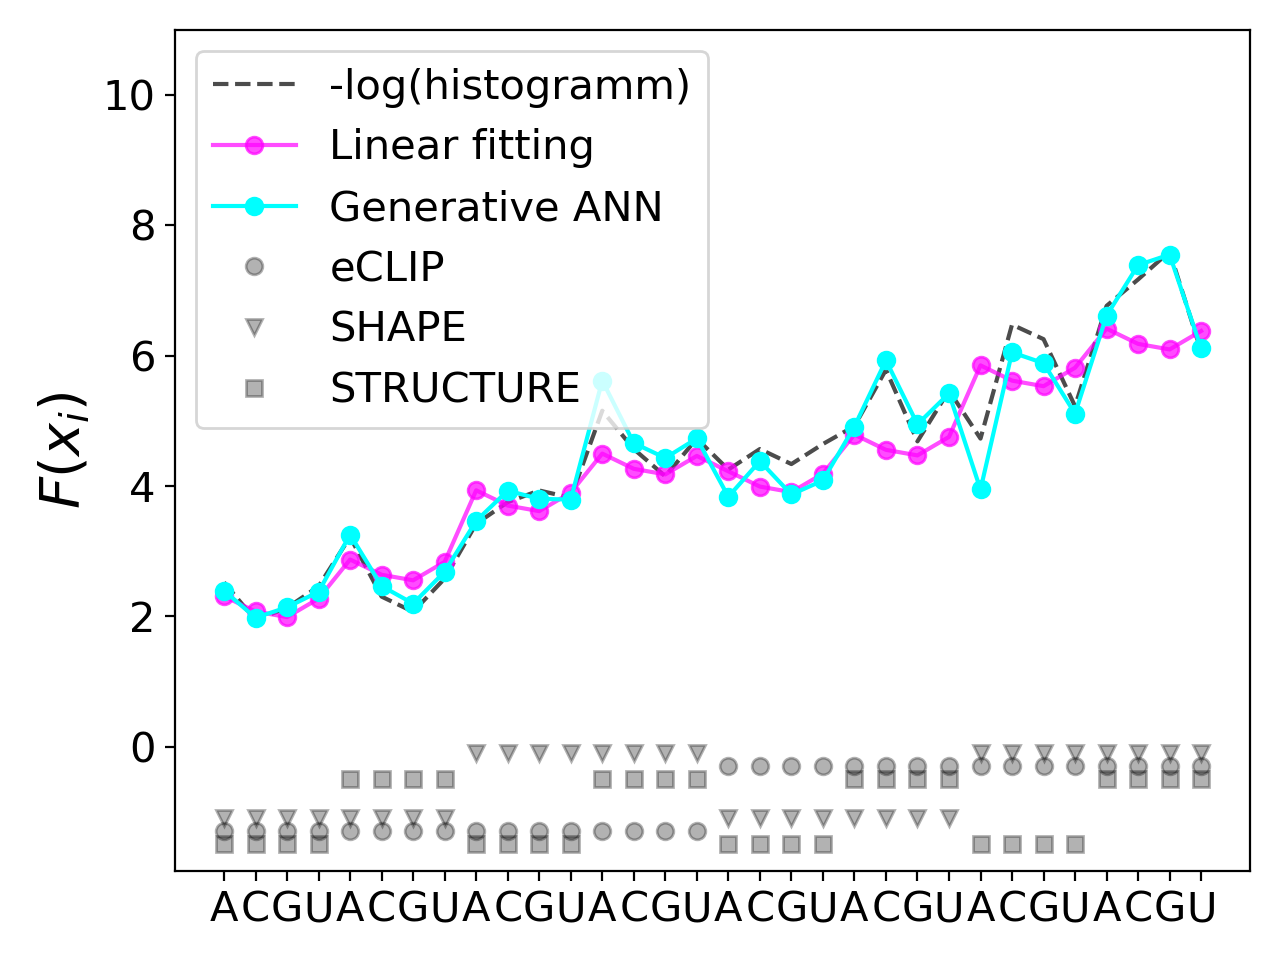

In [19]:
one_hot_encoding = {str(np.array([0,0,0,1])): 'A', str(np.array([0,0,1,0])): 'C',str(np.array([0,1,0,0])): 'G',str(np.array([1,0,0,0])): 'U'}

def also_mapping_bit_encode(input_array):
    output=[]
    for e in input_array:
        #print(e)
        output.append((one_hot_encoding[np.array_str(e)]))
    output=np.array(output)
    return output

letter_SEQUENCE=also_mapping_bit_encode(SEQUENCE_all_states[0])


plt.figure()
plt.plot(-np.log(ave_dU),'--',color='black',alpha=0.7,label='-log(histogramm)',zorder=1)
plt.plot(lin_F,'o-',color='magenta',alpha=0.7,label='Linear fitting',zorder=1)
plt.plot(F,'o-',color='cyan',alpha=1,label='Generative ANN',zorder=2)

plt.plot(eCLIP_all_states[0]-1.5+0.2,'o',color='black',alpha=0.3,label='eCLIP',zorder=3)
plt.plot(SHAPE_all_states[0]-1.5+0.4,'v',color='black',alpha=0.3,label='SHAPE',zorder=4)
plt.plot(STRUCTURE_all_states[0]-1.5,'s',color='black',alpha=0.3,label='STRUCTURE',zorder=5)

plt.ylabel('$F(x_i)$',fontsize=20)
plt.ylim(-1.9,11)
plt.yticks(fontsize=15)
plt.xticks(ticks=np.arange(len(letter_SEQUENCE)),labels=letter_SEQUENCE,fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()

plt.show()